In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
IMG_RES = 128
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = './dataset/'
CATEGORIES = ["Mask", "No_Mask"]

In [3]:
data = []
labels = []
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path)
        image = img_to_array(image)
        image = cv2.resize(image, (IMG_RES, IMG_RES))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        data.append(image)
        labels.append(category)

data = np.array(data) / 255.0
data = np.reshape(data, (data.shape[0], IMG_RES, IMG_RES, 1))
labels = np.array(labels)

D:\Programming\Anaconda\envs\mask\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.25, 
                                                    stratify=labels, 
                                                    random_state=42)

In [5]:
model=Sequential()

model.add(Conv2D(200, (3, 3), input_shape=(IMG_RES, IMG_RES, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(100, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 200)     2000      
_________________________________________________________________
activation (Activation)      (None, 126, 126, 200)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 90000)             0

In [6]:
augs_test = ImageDataGenerator()
augs_train = ImageDataGenerator(zoom_range=0.15,
                                shear_range=0.15,
                                rotation_range=20,
                                fill_mode="nearest",
                                horizontal_flip=True,
                                width_shift_range=0.2,
                                height_shift_range=0.2)

In [7]:
checkpoint = ModelCheckpoint('./mask_detector/model.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='auto',
                             verbose=0)
    
history = model.fit(augs_train.flow(X_train, y_train, batch_size=BS),
                    validation_data=augs_test.flow(X_test, y_test, batch_size=BS),
                    callbacks=[checkpoint],
                    epochs=EPOCHS)

Epoch 1/20
107/107 [==============================] - 14s 91ms/step - loss: 0.6764 - acc: 0.5758 - val_loss: 0.6642 - val_acc: 0.5810
Epoch 2/20
107/107 [==============================] - 8s 75ms/step - loss: 0.6542 - acc: 0.5923 - val_loss: 0.6544 - val_acc: 0.5880
Epoch 3/20
107/107 [==============================] - 8s 75ms/step - loss: 0.6314 - acc: 0.6295 - val_loss: 0.6072 - val_acc: 0.6479
Epoch 4/20
107/107 [==============================] - 8s 75ms/step - loss: 0.6097 - acc: 0.6818 - val_loss: 0.5505 - val_acc: 0.7790
Epoch 5/20
107/107 [==============================] - 8s 76ms/step - loss: 0.5541 - acc: 0.7229 - val_loss: 0.4684 - val_acc: 0.8134
Epoch 6/20
107/107 [==============================] - 8s 76ms/step - loss: 0.4999 - acc: 0.7747 - val_loss: 0.4098 - val_acc: 0.8407
Epoch 7/20
107/107 [==============================] - 8s 76ms/step - loss: 0.4645 - acc: 0.7875 - val_loss: 0.3995 - val_acc: 0.8424
Epoch 8/20
107/107 [==============================] - 8s 76ms/step -

In [8]:
preds = model.predict(X_test, batch_size=BS)
preds = np.argmax(preds, axis=1)
print(classification_report(y_test.argmax(axis=1), preds, target_names=lb.classes_))

              precision    recall  f1-score   support

        Mask       0.96      0.89      0.92       652
     No_Mask       0.86      0.95      0.90       484

    accuracy                           0.91      1136
   macro avg       0.91      0.92      0.91      1136
weighted avg       0.92      0.91      0.91      1136



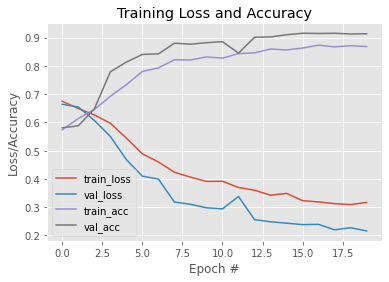

In [9]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()